## PART 1 Data Acquisition

In [46]:
from bs4 import BeautifulSoup
import pandas as pd
import urllib.request
import re
import time

# lists to store the data
ranks = []
title_lengths = []
age_in_hours = []
points = []
comment_counts = []

# Loop through the first 5 pages
for i in range(5):
    url= "https://news.ycombinator.com/?p=" + str(i+1)
    
    # read and decode page 
    with urllib.request.urlopen (url) as response:
        html = response.read()
        html = html.decode("utf-8")
    
    # save the HTML page content
    with open ("hackernews" + str(i+1) + ".html", "w") as new_file:
        new_file.write(html)
    
    # parse the HTML content stored in html and save as 'soup'
    parsedPage = BeautifulSoup(html, 'html.parser')

    #scraping rank
    for post in parsedPage.find_all(class_="rank"):
        rank = str(post.text)
        rank = rank.replace('.','')
        ranks.append(int(rank))

    #scraping length of title
    for title in parsedPage.find_all(class_="titleline"):
        title_lengths.append(len(title.text))

    #scraping age of post
    for age  in parsedPage.find_all(class_="age"):
        age_str = str(age.text)
        age_str = age_str.removesuffix(" hours ago")
        age_str = age_str.removesuffix(" hour ago")
        
        # 1 day ago, converted to 24 hours
        if " day ago" in age_str:
            age_in_hours.append(24)
        elif " days ago" in age_str:
            modified_string = age_str.replace(" days ago", "")
            age_int = int(modified_string)
            age_in_hours.append(24*age_int)
        elif " minutes ago" in age_str:
            age_in_hours.append(0)
        elif " minute ago" in age_str:
            age_in_hours.append(0)
        else:
            age_in_hours.append(int(age_str))

    #scraping points and comments
    for subtext in parsedPage.find_all(class_="subtext" ):
        point = 0
        comments = 0
        for score in subtext.find_all(class_="score"):
            # extract the number from the text
            point = int(re.search(r'\d+', str(score.text)).group())

        for anchorTag in subtext.find_all("a"):
            if anchorTag.text.endswith("comments"):
                a_string = str(anchorTag.text)
                # extract the number from the text
                comments = int(re.search(r'\d+', a_string).group())
        comment_counts.append(int(comments))
        points.append(int(point))
    
    # avoid overloading the server    
    time.sleep(5)


# creating a data frame
submissions_df = pd.DataFrame({"rank": ranks, "title_lengths": title_lengths, "age_in_hours": age_in_hours, "points": points, "comment_counts": comment_counts})
print(submissions_df)

# save as csv file
submissions_df.to_csv('hackerPosts.csv', index=False)

     rank  title_lengths  age_in_hours  points  comment_counts
0       1             74             1      40              10
1       2             93            14     843             155
2       3             80             0       7               0
3       4             78             1      38              13
4       5             34            11     295             289
..    ...            ...           ...     ...             ...
145   146             89            10       8               0
146   147             23             8      31              17
147   148             81            48     100              70
148   149             43            48      50               4
149   150             60            48     351              93

[150 rows x 5 columns]


## Part 2 Regression

In [47]:
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt

submissions_df = pd.read_csv('hackerPosts.csv')

# rank predicted by comment_counts, points, and age_in_hours
count_points_age_ols = sm.ols(formula="rank ~ comment_counts + points + age_in_hours", data=submissions_df).fit()
count_points_age_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     23.86
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           1.27e-12
Time:                        20:31:55   Log-Likelihood:                -748.15
No. Observations:                 150   AIC:                             1504.
Df Residuals:                     146   BIC:                             1516.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         55.6553      4.486     12.405      0.000      46.789      64.522
comment_counts     0.0269      0.048      0.560      0.576      -0.068       0.122
points            -0.1229      0.031     -3.995      0.000      -0.184      -0.062
age_in_hours       2.1377      0.254      8.428      0.000       1.636       2.639
==============================================================================
Omnibus:                        9.951   Durbin-Watson:                   0.728
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                5.320
Skew:                           0.261   Prob(JB):                       0.0699
Kurtosis:                       2.239   Cond. No.                         288.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Rank predicted by comment_counts, points, and age_in_hours
R squared = .336
P value:
- comment_counts = .459
- points = 0.0
- age_in_hours = 0.0


In [48]:
#rank predicted by age
age_rank_ols = sm.ols(formula="rank ~ age_in_hours", data=submissions_df).fit()
age_rank_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     43.86
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           6.11e-10
Time:                        20:31:55   Log-Likelihood:                -758.60
No. Observations:                 150   AIC:                             1521.
Df Residuals:                     148   BIC:                             1527.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       52.6458      4.656     11.306      0.000      43.444      61.847
age_in_hours     1.5604      0.236      6.623      0.000       1.095       2.026
==============================================================================
Omnibus:                       10.558   Durbin-Watson:                   0.502
Prob(Omnibus):                  0.005   Jarque-Bera (JB):                4.617
Skew:                           0.152   Prob(JB):                       0.0994
Kurtosis:                       2.196   Cond. No.                         29.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Rank predicted by age_in_hours

R-squared = .257
P value = 0.00

In [49]:
#rank predicted points + comments
rank_points_ols = sm.ols(formula="rank ~ comment_counts + points", data=submissions_df).fit()
rank_points_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.1782
Date:                Mon, 03 Jun 2024   Prob (F-statistic):              0.837
Time:                        20:31:55   Log-Likelihood:                -777.88
No. Observations:                 150   AIC:                             1562.
Df Residuals:                     147   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         77.0998      4.490     17.171      0.000      68.226      85.973
comment_counts    -0.0130      0.058     -0.223      0.824      -0.128       0.102
points            -0.0095      0.034     -0.281      0.779      -0.076       0.057
==============================================================================
Omnibus:                       69.099   Durbin-Watson:                   0.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.362
Skew:                           0.020   Prob(JB):                      0.00927
Kurtosis:                       1.777   Cond. No.                         237.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Rank predicted by comment_counts and points

R-squared = 0
P-value:
- comment count = .993
- points = .940

In [50]:
#rank predicted by points + age
rank_points_ols = sm.ols(formula="rank ~ points + age_in_hours", data=submissions_df).fit()
rank_points_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     35.79
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           2.17e-13
Time:                        20:31:55   Log-Likelihood:                -748.31
No. Observations:                 150   AIC:                             1503.
Df Residuals:                     147   BIC:                             1512.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       56.0407      4.423     12.670      0.000      47.300      64.782
points          -0.1123      0.024     -4.649      0.000      -0.160      -0.065
age_in_hours     2.1237      0.252      8.434      0.000       1.626       2.621
==============================================================================
Omnibus:                       10.101   Durbin-Watson:                   0.711
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                5.591
Skew:                           0.284   Prob(JB):                       0.0611
Kurtosis:                       2.244   Cond. No.                         262.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Rank predicted by points and age
R-squared = .336
P value:
- points = 0.0
- age = 0.0


### Observations
The closer a R-square value is to 1, the stronger the correlation and the closer a P-value is to 0 the more significant the prediction is. 

Based off this, we can determine points and age together are the best indicator of rank, with their model explaining 36.6% of variability in rank. 

The coeff for points is -0.1133 and for age is 2.2187. This is note worthy because it means that as points go up, the rank will go slightly down. 




## Part 3 Classification

Optimization terminated successfully.
         Current function value: 0.418898
         Iterations 6


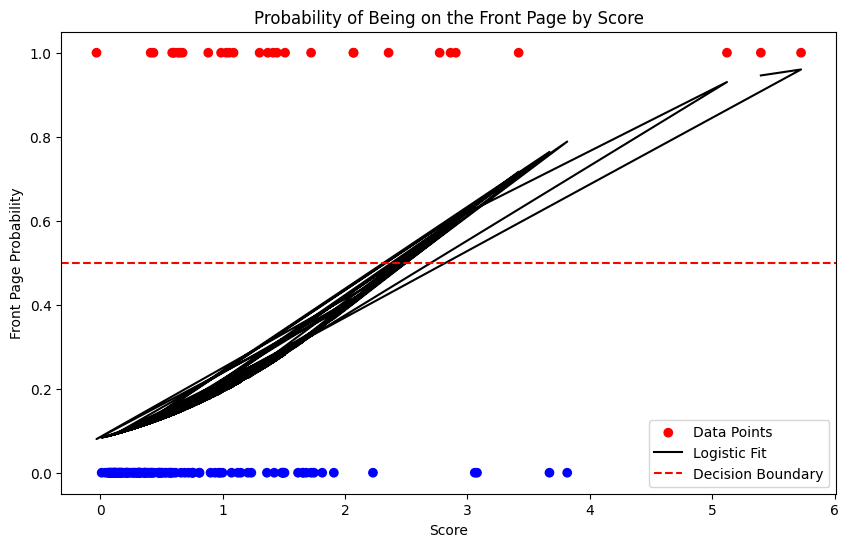

                           Logit Regression Results                           
Dep. Variable:             Front Page   No. Observations:                  150
Model:                          Logit   Df Residuals:                      148
Method:                           MLE   Df Model:                            1
Date:                Mon, 03 Jun 2024   Pseudo R-squ.:                  0.1629
Time:                        20:31:55   Log-Likelihood:                -62.835
converged:                       True   LL-Null:                       -75.060
Covariance Type:            nonrobust   LLR p-value:                 7.621e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4115      0.342     -7.048      0.000      -3.082      -1.741
Score          0.9767      0.234      4.179      0.000       0.519       1.435


In [51]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Compute 'Front Page' binary variable
submissions_df['Front Page'] = np.where(submissions_df['rank'] <= 30, 1, 0)
# Add 'Score' column (post's engagement relative to its age and points)
submissions_df['Score'] = (submissions_df['points'] - 1) / (submissions_df['age_in_hours'] + 2) ** 1.8

# Logistic Regression Model
logit_model = sm.Logit(submissions_df['Front Page'], sm.add_constant(submissions_df[['Score']]))
result = logit_model.fit()

# PLOT
plt.figure(figsize=(10, 6))

# scatter plot data points are colored based on their front page status
plt.scatter(submissions_df['Score'], submissions_df['Front Page'], c=['red' if x else 'blue' for x in submissions_df['Front Page']], label='Data Points')

# logistic regression curve 
predicted_probs = result.predict(sm.add_constant(submissions_df[['Score']]))
plt.plot(submissions_df['Score'], predicted_probs, color='black', label='Logistic Fit')

# decision boundary
plt.axhline(0.5, color='red', linestyle='--', label='Decision Boundary')

plt.xlabel('Score')
plt.ylabel('Front Page Probability')
plt.title('Probability of Being on the Front Page by Score')
plt.legend()
plt.show()

# Print the summary of the logistic regression
print(result.summary())


**Pseudo R-squared (0.1629):**  The model explains about 16.29% of the variability in the front page status, which is relatively poor explanatory power.

**Log-Likelihood and LL-Null:** The log-likelihood of the model is -62.835, compared to -75.060 for the model with no predictors (LL-Null). This improvement indicates that the model with predictors fits the data significantly better than a null model.

**Score Coefficient:** 0.9767 with a standard error of 0.234. This positive coefficient indicates that higher scores significantly increase the log odds of a post being on the front page. The coefficient is statistically significant (P < 0.001), showing strong evidence that higher engagement relative to their age and points are more likely to appear on the front page.